In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd
import numpy as np

# 1. Read Original Data 

## 1.1 Load Original Dataset

Remember to change the path to read data

In [2]:
df_problem = pd.read_csv('./Data/round1-day1_problem_data.csv')
burrito_price = float(df_problem['burrito_price'][0])
ingredient_cost = float(df_problem['ingredient_cost'][0])
truck_cost = float(df_problem['truck_cost'][0])
print(f"  - The burritos cost ₲{ingredient_cost} to make and are sold for ₲{burrito_price}. Each truck costs ₲{truck_cost} to use per day.")

df_truck_node = pd.read_csv('./Data/round1-day1_truck_node_data.csv')
truck_coordinates = {row['index']:(float(row['x']),float(row['y'])) for ind,row in df_truck_node.iterrows()}
truck_spots = truck_coordinates.keys()
print(f"  - There are {len(truck_spots)} available 'truck_spots' or places where a truck can be placed around Burritoville.")

df_demand = pd.read_csv('./Data/round1-day1_demand_node_data.csv')
buildings, building_names, building_coordinates, demand = gp.multidict({
        row['index']: [row['name'], (float(row['x']), float(row['y'])), float(row['demand'])] for ind,row in df_demand.iterrows()
    })
print(f"  - There are in {len(buildings)} buildings with hungry customers also known as demand nodes.")

df_truck_demand_pair = pd.read_csv('./Data/round1-day1_demand_truck_data.csv')
building_truck_spot_pairs, distance, scaled_demand = gp.multidict({
        (row['demand_node_index'], row['truck_node_index']): [float(row['distance']), float(row['scaled_demand'])] for ind,row in df_truck_demand_pair.iterrows() if float(row['scaled_demand'])>0# (building, truck_spot): distance, scaled_demand
    })
print(f"  - There are in {len(building_truck_spot_pairs)} pairs of trucks spots and buildings with hungry customers.")

  - The burritos cost ₲5.0 to make and are sold for ₲10.0. Each truck costs ₲250.0 to use per day.
  - There are 15 available 'truck_spots' or places where a truck can be placed around Burritoville.
  - There are in 15 buildings with hungry customers also known as demand nodes.
  - There are in 100 pairs of trucks spots and buildings with hungry customers.


## 1.2 Drawing the map

In [4]:
import plotly.graph_objects as go
from PIL import Image
import requests
from io import BytesIO #try 1

def show_map(buildings, building_names, building_coordinates, demand, truck_coordinates, placed_trucks = []):
    """displays the Burrito Optimization map with labels for open truck locations, buildings with demand, and placed trucks [optional].  This is intended to be used in the Gurobi Days Intro to Modeling course"""

    y_max = 550

    truck_spot_x = [value[0] for key, value in truck_coordinates.items()]
    truck_spot_y = [y_max - value[1] for key, value in truck_coordinates.items()]
    trucks = [key for key, value in truck_coordinates.items()]

    building_x = [value[0] for key, value in building_coordinates.items()]
    building_y = [y_max - value[1] for key, value in building_coordinates.items()]
    demand = [value for key, value in demand.items()]
    building_names = [value for key, value in building_names.items()]

    if placed_trucks:
        placed_truck_spot_x = [value[0] for key, value in truck_coordinates.items() if key in placed_trucks]
        placed_truck_spot_y = [y_max - value[1] for key, value in truck_coordinates.items() if key in placed_trucks]
        placed_trucks = [key for key, value in truck_coordinates.items() if key in placed_trucks]

    map = Image.open('map.png')
    fig = go.Figure()

    # Add trace for truck spots
    fig.add_trace(
        go.Scatter(x=truck_spot_x, y=truck_spot_y,
                   hovertemplate=trucks,
                   name="Open truck spots",
                   mode='markers',
                   marker_color='rgba(135, 206, 250, 0.0)',
                   marker_line_color='darkblue',
                   marker_line_width=2,
                   marker_size=10
                   )
    )

    # Add trace for placed trucks
    if placed_trucks:
        fig.add_trace(
            go.Scatter(x=placed_truck_spot_x, y=placed_truck_spot_y,
                       hovertemplate=placed_trucks,
                       name="Truck added to the map",
                       mode='markers',
                       marker_color='darkblue',
                       marker_line_color='darkblue',
                       marker_line_width=2,
                       marker_size=10
                       )
        )

    # Add trace for buildings
    fig.add_trace(
        go.Scatter(x=building_x, y=building_y,
                   hovertemplate=building_names,
                   name="Buildings with customer demand",
                   mode='markers',
                   marker_color='red',
                   marker_opacity=0.5,
                   marker_line_width=0,
                   marker_size=demand
                   )
    )

    # Add minimap image
    fig.add_layout_image(
            dict(
                source=map,
                xref="x",
                yref="y",
                x=0,
                y=550,
                sizex=500,
                sizey=550,
                sizing="stretch",
                opacity=0.9,
                layer="below")
    )

    # Set templates
    fig.update_layout(template="simple_white")
    fig.update_xaxes(range=[0, 500], visible=False)
    fig.update_yaxes(range=[0,550], visible=False,
                    scaleanchor = "x",scaleratio = 1)
    fig.update_layout(showlegend=True)

    fig.update_layout(
        title="Burrito Optimization Game Map",
    )

    fig.show()



In [5]:
#from show_map_local import show_map

show_map(buildings, building_names, building_coordinates, demand, truck_coordinates)

# 2. Data Generation

## 2.1 Generate Preference Matrix

We regenerate the scaled_demand data(the deal between customer and truck) by make a preference matrix with a exp funtion of distance.

In [6]:
import math
def generate_scaled_demand(df_scaled,df_demand_node):
    """
    df_scaled: the demand-truck pairs dataset
    df_demand_node: the demand node dataset
    """
    df_rescaled = df_scaled.copy()

    #del(dict)
    my_dict = dict(zip(df_demand_node['index'], df_demand_node['demand']))
    df_rescaled['demand'] = df_rescaled['demand_node_index'].map(my_dict)

    # Step1:Calculate the total distance of each demand node for all truck node
    distance_sums = df_rescaled.groupby('demand_node_index')['distance'].transform('sum')

    # Step2:Calculate the value of new column
    beta = 10
    df_rescaled['scaled_demand'] = (np.exp(-beta * (df_rescaled['distance'] / distance_sums))) * df_rescaled['demand']
    df_rescaled['scaled_demand'] = df_rescaled['scaled_demand'].astype(int)

    df_rescaled = df_rescaled.drop(columns=['demand'])

    return df_rescaled

In [7]:
df_scaled = generate_scaled_demand(df_truck_demand_pair,df_demand)
df_scaled

,demand_node_index,truck_node_index,distance,scaled_demand
0,demand2,truck1,231.108640,20
1,demand2,truck6,201.157571,21
2,demand2,truck7,161.831991,22
3,demand2,truck8,113.778542,24
4,demand2,truck17,289.327111,18
...,...,...,...,...
220,demand51,truck36,298.355857,26
221,demand51,truck37,379.099609,22
222,demand51,truck43,408.808936,21
223,demand51,truck49,482.584417,18


# 3. LP Model and Solution

## 3.1 Load the Data

In [3]:
def parameter_read(df_problem,df_truck_node,df_demand,df_scaled):
    burrito_price = float(df_problem['burrito_price'][0])
    ingredient_cost = float(df_problem['ingredient_cost'][0])

    truck_coordinates = {row['index']:(float(row['x']),float(row['y'])) for ind,row in df_truck_node.iterrows()}
    truck_spots = truck_coordinates.keys()

    buildings, building_names, building_coordinates, demand = gp.multidict({
        row['index']: [row['name'], (float(row['x']), float(row['y'])), float(row['demand'])] for ind,row in df_demand.iterrows()
    })

    building_truck_spot_pairs, distance, scaled_demand = gp.multidict({
        (row['demand_node_index'], row['truck_node_index']): [float(row['distance']), float(row['scaled_demand'])] for ind,row in df_scaled.iterrows() if float(row['scaled_demand'])>0# (building, truck_spot): distance, scaled_demand
    })

    return burrito_price, ingredient_cost,truck_coordinates,truck_spots,buildings,building_names,building_coordinates,demand,scaled_demand

In [9]:
# Read data in files
burrito_price, ingredient_cost,truck_coordinates,truck_spots,buildings,building_names,building_coordinates,demand,scaled_demand = parameter_read(df_problem,df_truck_node,df_demand,df_truck_demand_pair)

## 3.2 Build Up the LP Model

In [10]:
truck_spots

dict_keys(['truck1', 'truck6', 'truck7', 'truck8', 'truck17', 'truck27', 'truck29', 'truck33', 'truck34', 'truck35', 'truck36', 'truck37', 'truck43', 'truck49', 'truck54'])

In [11]:
building_truck_spot_pairs

<gurobi.tuplelist (100 tuples, 2 values each):
 ( demand2  , truck1  )
 ( demand2  , truck6  )
 ( demand2  , truck7  )
 ( demand2  , truck8  )
 ( demand2  , truck17 )
 ( demand11 , truck8  )
 ( demand11 , truck17 )
 ( demand11 , truck27 )
 ( demand11 , truck29 )
 ( demand11 , truck34 )
 ( demand11 , truck35 )
 ( demand11 , truck36 )
 ( demand11 , truck54 )
 ( demand12 , truck6  )
 ( demand12 , truck7  )
 ( demand12 , truck8  )
 ( demand12 , truck17 )
 ( demand12 , truck27 )
 ( demand12 , truck54 )
 ( demand14 , truck6  )
 ( demand14 , truck7  )
 ( demand14 , truck8  )
 ( demand14 , truck17 )
 ( demand14 , truck27 )
 ( demand14 , truck54 )
 ( demand16 , truck1  )
 ( demand16 , truck6  )
 ( demand16 , truck7  )
 ( demand16 , truck8  )
 ( demand16 , truck17 )
 ( demand16 , truck27 )
 ( demand17 , truck7  )
 ( demand17 , truck8  )
 ( demand17 , truck27 )
 ( demand18 , truck7  )
 ( demand18 , truck8  )
 ( demand18 , truck17 )
 ( demand18 , truck27 )
 ( demand18 , truck29 )
 ( demand18 , tru

In [12]:
truck_spots

dict_keys(['truck1', 'truck6', 'truck7', 'truck8', 'truck17', 'truck27', 'truck29', 'truck33', 'truck34', 'truck35', 'truck36', 'truck37', 'truck43', 'truck49', 'truck54'])

In [13]:
def LP_solution(burrito_price, ingredient_cost,truck_cost,scaled_demand,truck_spots,buildings, work_name,write_lp_file=True,show_model=True,is_show_map=True):
    """Read all parameters, build up the model and solve the problem"""
    # Declare and initialize model
    model = gp.Model("LP Model Solution")
    model.Params.OutputFlag = int(show_model)

    # Create decision variables for the Burrito Optimization Game model
    x_placed = model.addVars(truck_spots, vtype=GRB.BINARY, name="x_placed")
    y_served = model.addVars(building_truck_spot_pairs, vtype=GRB.BINARY, name="y_served")

    # Create truck-must-exist constraints
    cons1 = model.addConstrs((y_served[b,t] <= x_placed[t] for b,t in building_truck_spot_pairs), name = "Ensure_truck_spot_open_to_serve")

    # Create only one truck per customers at building constraint
    cons2 = model.addConstrs((y_served.sum(b,'*') <= 1 for b in buildings),
                        name="Ensure_one_truck_per_customers_at_building") # buildings 就是 demand node
    
    # Objective: maximize total profit = burrito_revenue - total_truck_cost
    burrito_revenue = (burrito_price - ingredient_cost)*y_served.prod(scaled_demand) # This is the nested summation
    total_truck_cost = truck_cost*x_placed.sum('*')
    
    model.setObjective(burrito_revenue - total_truck_cost, GRB.MAXIMIZE)

    # write a lp file to store the model
    if write_lp_file:
        model.write(f'{work_name}.lp')

    model.optimize()
    status = model.status

    # if results need to be shown
    if show_model:
        if status == GRB.OPTIMAL:
            print(f"The final objective is ")
            print(f"     Burrito revenue        ₲{burrito_revenue.getValue()}")
            print(f" -  Total truck cost     -  ₲{total_truck_cost.getValue()}")
            print(f"-----------------------------------")
            print(f"              Profit        ₲{model.objVal}")
        else:
            print(f"Model is not optimal, status = {status}")
    
    # show the result in map
    if is_show_map:
        # Plot the solution on the Burritoville Map
        placed_trucks = [t for t in x_placed if x_placed[t].X ==1]
        show_map(buildings, building_names, building_coordinates, demand, truck_coordinates, placed_trucks = placed_trucks)

    return model.ObjVal # return optimal value

## 3.3 Running the Model

In [14]:
# Solve the original problem
work_name = "Part 1 Original Problem"
optimal_value = LP_solution(burrito_price, ingredient_cost,truck_cost,scaled_demand,truck_spots,buildings, work_name = work_name,write_lp_file=True,show_model=True,is_show_map=True)

Restricted license - for non-production use only - expires 2026-11-23
Set parameter OutputFlag to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 7 7840HS w/ Radeon 780M Graphics, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 115 rows, 115 columns and 300 nonzeros
Model fingerprint: 0xd4be4e7f
Variable types: 0 continuous, 115 integer (115 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+00, 3e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective -0.0000000
Presolve removed 9 rows and 12 columns
Presolve time: 0.01s
Presolved: 106 rows, 103 columns, 273 nonzeros
Variable types: 0 continuous, 103 integer (103 binary)

Root relaxation: objective 5.950000e+02, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    

# 4. Sensitivity Analysis

## 4.1 Data Generation for Analysis

What to be varied:

- Fixed truck cost
- Ingredient cost
- A high-demand customer disappears

## 4.2 Sensitivity Analysis Programming

Based on the varied data, we analyze the effects of varied data in pairs. (e.g. different truck cost with 5 demand decreased)

In [15]:
df_demand

,index,name,x,y,demand
0,demand2,ReLU Realty,190.720688,72.661102,30
1,demand11,Reinforcement Learning Puppy Training,284.838551,188.794658,5
2,demand12,KKT Air Conditioning,256.572130,158.053422,50
3,demand14,George's Basic Diet Solutions,213.706568,160.537563,35
4,demand16,Rothberg Tower,129.217925,168.611018,30
5,demand17,Multimodal Distribution Center,68.025783,229.782972,5
6,demand18,Callback Cat Café,187.614487,222.641068,50
7,demand22,Vertex Tower,342.924494,231.335559,10
8,demand26,Nonlinear Thinking Center,356.281154,317.038397,5
9,demand33,Interior Point Decorating,267.133211,362.063439,40


### 4.2.1 Sensitivity Analysis of varied truck cost with decreased demand

In [16]:
data_list = []

for delta in [1,5,10]:
    # Create new demand dataframe
    df_new_demand = df_demand.copy()
    df_new_demand['demand'] = df_new_demand['demand'].where(
        df_new_demand['demand'] <= df_new_demand['demand'].mean(),
        df_new_demand['demand'] - delta
    )
    df_truck_demand_pair = generate_scaled_demand(df_truck_demand_pair,df_new_demand) # generate

    # Read data in files
    burrito_price, ingredient_cost,truck_coordinates,truck_spots,buildings,building_names,building_coordinates,demand,scaled_demand = parameter_read(df_problem,df_truck_node,df_new_demand,df_truck_demand_pair)

    for truck_cost in np.arange(0, 1000, 10):
        # solve the linear programming
        optimal_value = LP_solution(burrito_price, ingredient_cost,truck_cost,scaled_demand,truck_spots,buildings,work_name='', write_lp_file=False,show_model=False,is_show_map=False)
        # store the optimal value in dictionary
        # (x: truck cost, y: optimal value, demand: decreased demand)
        data_list.append([truck_cost,optimal_value,delta])
        
        # print(optimal_value)


In [17]:
df_truck_cost_decreased_demand = pd.DataFrame(data_list, columns=['truck_cost', 'optimal_value', 'decreased_demand'])
df_truck_cost_decreased_demand

,truck_cost,optimal_value,decreased_demand
0,0,1510.0,1
1,10,1455.0,1
2,20,1410.0,1
3,30,1370.0,1
4,40,1330.0,1
...,...,...,...
295,950,-0.0,10
296,960,-0.0,10
297,970,-0.0,10
298,980,-0.0,10


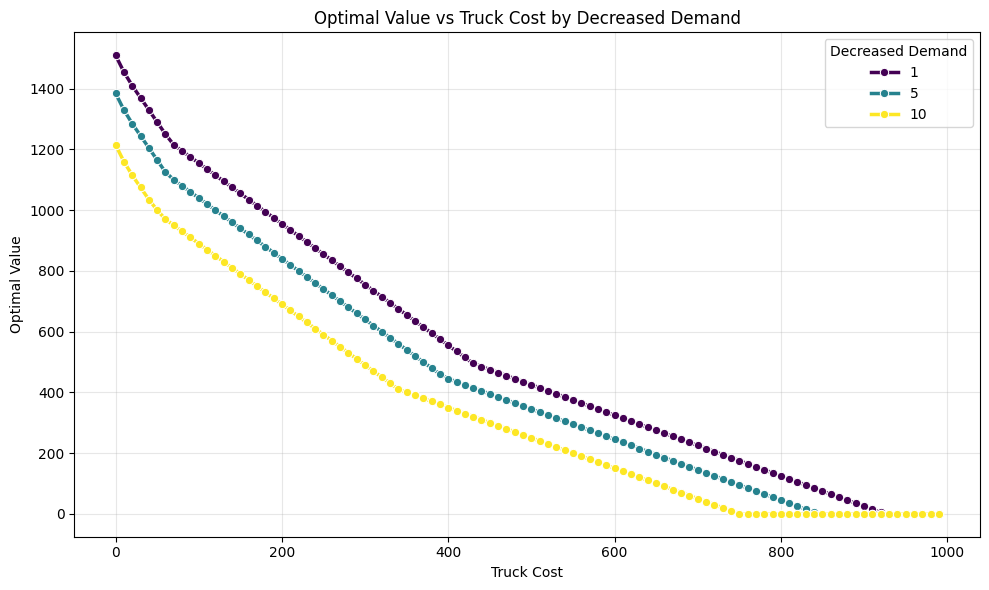

In [ ]:
# make the line graph of different truck cost , lines represent different decreased demand
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

# use the lineplot function in seaborn,different decreased_demand is differentiated by hue parameter
sns.lineplot(
    data=df_truck_cost_decreased_demand,
    x='truck_cost',
    y='optimal_value',
    hue='decreased_demand',
    marker='o',  
    palette='viridis',
    linewidth=2.5
)

plt.title('Optimal Value vs Truck Cost by Decreased Demand')
plt.xlabel('Truck Cost')
plt.ylabel('Optimal Value')
plt.grid(True, alpha=0.3)
plt.legend(title='Decreased Demand')
plt.tight_layout()
plt.show()

### Sensitivity Analysis of varied ingredient cost with decreased demand

In [19]:
df_demand

,index,name,x,y,demand
0,demand2,ReLU Realty,190.720688,72.661102,30
1,demand11,Reinforcement Learning Puppy Training,284.838551,188.794658,5
2,demand12,KKT Air Conditioning,256.572130,158.053422,50
3,demand14,George's Basic Diet Solutions,213.706568,160.537563,35
4,demand16,Rothberg Tower,129.217925,168.611018,30
5,demand17,Multimodal Distribution Center,68.025783,229.782972,5
6,demand18,Callback Cat Café,187.614487,222.641068,50
7,demand22,Vertex Tower,342.924494,231.335559,10
8,demand26,Nonlinear Thinking Center,356.281154,317.038397,5
9,demand33,Interior Point Decorating,267.133211,362.063439,40


Truck cost needs to be reloaded for this part

In [20]:
data_list = []

for delta in [1,5,10]:
    # Create new demand dataframe
    df_new_demand = df_demand.copy()
    df_new_demand['demand'] = df_new_demand['demand'].where(
        df_new_demand['demand'] <= df_new_demand['demand'].mean(),
        df_new_demand['demand'] - delta
    )

    df_truck_demand_pair = generate_scaled_demand(df_truck_demand_pair,df_new_demand) # generate

    # Read data in files
    burrito_price, ingredient_cost,truck_coordinates,truck_spots,buildings,building_names,building_coordinates,demand,scaled_demand = parameter_read(df_problem,df_truck_node,df_new_demand,df_truck_demand_pair)
    
    # truck cost needs to be reloaded
    truck_cost = 250

    for ingredient_cost in np.arange(0, 10, 0.1):
        # solve the linear programming
        optimal_value = LP_solution(burrito_price, ingredient_cost,truck_cost,scaled_demand,truck_spots,buildings,work_name='', write_lp_file=False,show_model=False,is_show_map=False)
        # store the optimal value in dictionary
        # (x: truck cost, y: optimal value, demand: decreased demand)
        data_list.append([ingredient_cost,optimal_value,delta])

In [21]:
df_ingredient_cost_decreased_demand = pd.DataFrame(data_list, columns=['ingredient_cost', 'optimal_value', 'decreased_demand'])

In [22]:
df_ingredient_cost_decreased_demand

,ingredient_cost,optimal_value,decreased_demand
0,0.0,2210.0,1
1,0.1,2182.9,1
2,0.2,2155.8,1
3,0.3,2128.7,1
4,0.4,2101.6,1
...,...,...,...
295,9.5,-0.0,10
296,9.6,-0.0,10
297,9.7,-0.0,10
298,9.8,-0.0,10


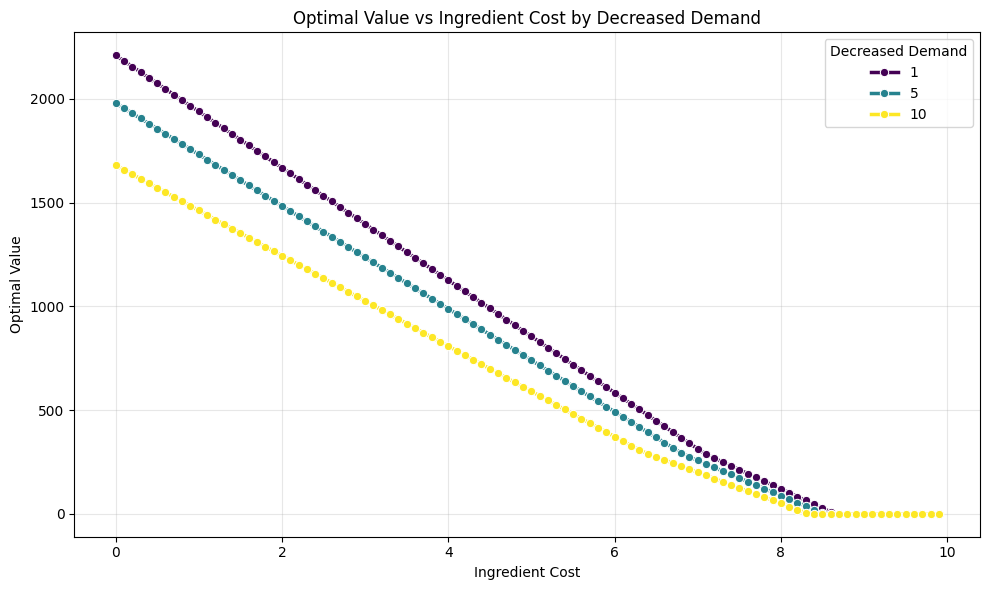

In [ ]:
# make the line graph of different truck cost , lines represent different decreased demand
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_ingredient_cost_decreased_demand,
    x='ingredient_cost',
    y='optimal_value',
    hue='decreased_demand',
    marker='o', 
    palette='viridis',
    linewidth=2.5
)

plt.title('Optimal Value vs Ingredient Cost by Decreased Demand')
plt.xlabel('Ingredient Cost')
plt.ylabel('Optimal Value')
plt.grid(True, alpha=0.3)
plt.legend(title='Decreased Demand')
plt.tight_layout()
plt.show()